# This notebook includes training and test of the peak ranging model

## Table of Contents
- [Supporting modules and functions](#Supporting-modules-and-functions)
- [Training data precheck](#Training-data-precheck)
- [Train](#Train)
- [Model prediction and evaluation](#Model-prediction-and-evaluation)

# Supporting modules and functions

In [1]:
import torch
import os,sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
from peak_detection.RangingNN.trainer import BaseTrainer
from peak_detection.RangingNN.model_utils import cw2lh
from pathlib import Path
import yaml
from peak_detection.RangingNN.predictor import DetectionPredictor
from peak_detection.RangingNN.metrics import box_iou
print('if GPU available:',torch.cuda.is_available(),'\npytorch version',torch.__version__)

if GPU available: True 
pytorch version 2.1.2+cu121


In [2]:
def predictionStats(file, num, iou_thres, 
                    modelpath= "/srv/home/jwei74/APT_ML/ranging/training_results0/weights/best.pt", save_dir=None):
    """
    Args:
    file: the h5 file path
    num: number of spectrums to be tested within the h5 file
    iou_thres: IOU threshold for the model
    returns recall, precision, low range absolute error, high range absolute error
    """
    cfg = '/srv/home/jwei74/APT_ML/ranging/prediction_args.yaml'
    with h5py.File(file, "r") as f:
        array = np.asarray(f['input'])[:num,None, :]
        array_raw = np.asarray(f['non_log_spectrums'])[:num,None, :]
        gt = np.asarray(f['label'])[:num]
        sp = torch.tensor(array, dtype=torch.float32)
        
    recall = np.zeros(sp.shape[0])
    precision = np.zeros(sp.shape[0])
    low_ae =[]
    high_ae = []
    sp_counts_ae = []

    for dataindex in range(sp.shape[0]):

        predictor = DetectionPredictor(modelpath, sp[dataindex], save_dir = save_dir, cfg = cfg)
        result = predictor()[0]
        pred_ranges = result[:,:2].cpu()
        gt_ranges = torch.as_tensor(cw2lh(gt[dataindex] * 30720))# target ranges denormalized, in pixels
        (tp, difference, pred_matched, gt_matched) = predictionMetrics(gt_ranges, pred_ranges, iou_thres)
        precision[dataindex] = tp.sum() / pred_ranges.shape[0]##########################
        recall[dataindex] = tp.sum() / gt_ranges.shape[0]##########################

        low_ae = low_ae + list(difference[:,0])
        high_ae = high_ae+ list(difference[:,1])
        for k in range(pred_matched.shape[0]):
            integrated_diff = array_raw[pred_matched[k][0]: pred_matched[k][1]].sum() - array_raw[gt_matched[k][0]: gt_matched[k][1]].sum()
            sp_counts_ae.append(integrated_diff)
    return recall, precision, torch.as_tensor(low_ae)*0.01, torch.as_tensor(high_ae)*0.01, torch.as_tensor(sp_counts_ae)

In [3]:
def predictionMetrics(gt_ranges, pred_ranges, iou_thres):
    """
    Args:
    pred_ranges (torch.Tensor): Tensor of shape [N, 2] representing detections.
        Each detection is of the format: low, high
    gt_ranges (torch.Tensor): Tensor of shape [M, 2] representing labels.
        Each label is of the format: low, high

    outputs:
    differences: Tensor of shape [#tp, 2] representing pred ranges - gt ranges in number of data points 
    """
    correct = np.zeros(pred_ranges.shape[0]).astype(bool)

    iou = box_iou(gt_ranges, pred_ranges).squeeze()
    iou = iou.cpu().numpy()

    matches = np.nonzero(iou >= iou_thres) # IoU > threshold and classes match
    matches = np.array(matches).T
    if matches.shape[0]:
        if matches.shape[0] > 1:
            matches = matches[iou[matches[:, 0], matches[:, 1]].argsort()[::-1]]
            matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
            matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
        differences = pred_ranges[matches[:, 1]] - gt_ranges[matches[:, 0]]
        correct[matches[:, 1].astype(int)] = True
    return (torch.as_tensor(correct, dtype=torch.bool), 
            torch.as_tensor(differences, dtype=torch.float32),
            torch.as_tensor(pred_ranges[matches[:, 1]], dtype=torch.int),
            torch.as_tensor(gt_ranges[matches[:, 0]], dtype=torch.int),)


In [4]:
def plot_prediction(dataindex, plot_max = 30000, plot_min = 0, log=True):
    predictor = DetectionPredictor(modelpath, sp[dataindex], save_dir = save_dir, cfg = cfg)
    result = predictor()[0]
    peak_ranges = result[:,:2].cpu()
    peak_ranges = peak_ranges[(peak_ranges[:,0] < plot_max) & (peak_ranges[:,0] >plot_min)]
    gt_ranges = cw2lh(gt[dataindex] * 30720) # target ranges denormalized, in pixels

    gt_ranges = gt_ranges[(gt_ranges[:,0] < plot_max) & (gt_ranges[:,0] >plot_min)]
    print('labeled peaks:', gt_ranges.shape[0],'; model predicted peaks:',peak_ranges.shape[0] )
    # Create the plot
    fig, ax = plt.subplots(figsize=(7, 4))
    
    # Plot the spectrum
    x = torch.linspace(plot_min,plot_max, plot_max - plot_min)
    if log:
        ax.plot(x[...,None], sp[dataindex].cpu()[..., plot_min:plot_max].T, 'k-', linewidth=1)
    else:
        ax.plot(x[...,None], array_raw[dataindex][..., plot_min:plot_max].T, 'k-', linewidth=1)

    # Add color boxes for each peak range
    for start, end in peak_ranges:
        ax.axvspan(start, end, alpha=0.3, color='red',label='Model prediction' if start == peak_ranges[0][0] else "")
    
    for start, end in gt_ranges:
        ax.axvspan(start, end, alpha=0.3, color='green',label='Ground Truth'if start == gt_ranges[0][0] else "")
        
    # Add vertical lines to show the boundaries of ranges
    for start, end in peak_ranges:
        ax.axvline(start, color='red', linestyle='--', alpha=0.7, lw = 0.7)
        ax.axvline(end, color='red', linestyle='--', alpha=0.7, lw = 0.7)
    
    for start, end in gt_ranges:
        ax.axvline(start, color='green', linestyle=':', alpha=0.7, lw = 0.5)
        ax.axvline(end, color='green', linestyle=':', alpha=0.7, lw = 0.5)
        
    # Set labels and title
    ax.set_xlabel('Spectrum index (0.01Da)')
    ax.set_ylabel('Intensity (counts)')
    
    # Adjust the plot layout
    plt.tight_layout()
    plt.legend()
    # Show the plot
    return fig,ax

# Training data precheck

- load a random file in the training data and see if the ground truth is correct
- You can run %matplotlib widget or %matplotlib notebook to activate interactive plot

In [17]:
datapath = '/srv/home/jwei74/APT_ML/ranging/hdf5s/V0/train/'
filelist = os.listdir(datapath)
k = 15
file = datapath + filelist[k]
import h5py, torch
import numpy as np
with h5py.File(file, "r") as f:
    array = np.asarray(f['input'])[:,None, :]
    gt = np.asarray(f['label'])
    sp = torch.tensor(array, dtype=torch.float32)

/tmp/ipykernel_470523/886877834.py:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  array = np.asarray(f['input'])[:,None, :]
/tmp/ipykernel_470523/886877834.py:9: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gt = np.asarray(f['label'])


labeled peaks: 58


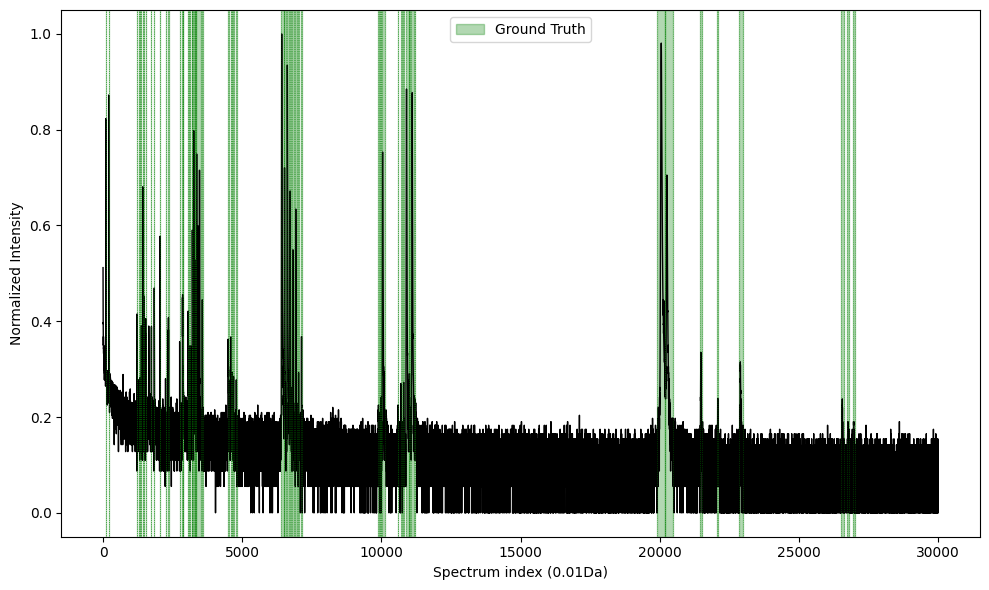

In [18]:
plot_min=0000
plot_max=30000
dataindex = 899
gt_ranges = cw2lh(gt[dataindex] * 30720)# target ranges denormalized, in pixels
gt_ranges = gt_ranges[(gt_ranges[:,0] < plot_max) & (gt_ranges[:,0] >plot_min)]
print('labeled peaks:', gt_ranges.shape[0], )
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the spectrum
x = torch.linspace(plot_min,plot_max, plot_max- plot_min)

ax.plot(x[...,None], sp[dataindex].cpu()[..., plot_min:plot_max].T, 'k-', linewidth=1)

for start, end in gt_ranges:
    ax.axvspan(start, end, alpha=0.3, color='green',label='Ground Truth'if start == gt_ranges[0][0] else "")


for start, end in gt_ranges:
    ax.axvline(start, color='green', linestyle=':', alpha=0.7, lw = 0.5)
    ax.axvline(end, color='green', linestyle=':', alpha=0.7, lw = 0.5)
    
# Set labels and title
ax.set_xlabel('Spectrum index (0.01Da)')
ax.set_ylabel('Normalized Intensity')

# Adjust the plot layout
plt.tight_layout()
plt.legend()

In [5]:
# check the dataset class for loading data for training
from peak_detection.RangingNN.dataset import BaseDataset, build_dataloader
dataset_path = '/srv/home/jwei74/APT_ML/ranging/hdf5s/V0/train/'
see = BaseDataset(dataset_path)

Scanning /srv/home/jwei74/APT_ML/ranging/hdf5s/V0/train/... 20 spectrums, 0 back


# Train


In [5]:
# load configuration file
yaml_dict = yaml.safe_load(Path("/srv/home/jwei74/APT_ML/ranging/current.yaml").read_text())

# initiate trainer
trainer = BaseTrainer(cfg=yaml_dict)

# run training
trainer.train()

Freezing layer 'model.20.dfl.conv.weight'


Scanning //srv/home/jwei74/APT_ML/ranging/hdf5s/V0//train... 20 spectrums, 0 bac
Scanning //srv/home/jwei74/APT_ML/ranging/hdf5s/V0//test... 1 spectrums, 0 backg


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 52 weight(decay=0.0), 59 weight(decay=0.0005), 58 bias(decay=0.0)
Image sizes 30720 train, 30720 val
Using 20 dataloader workers
Logging results to /srv/home/jwei74/APT_ML/ranging/model_latest_P234
Starting training for 10 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       1.9G      1.482      1.146      1.734        508  3.072e+04: 1



 on_validate


100%|██████████| 29/29 [00:29<00:00,  1.03s/it]


                   all        900      54000      0.567      0.605      0.455      0.241
on_model_save
on_fit_epoch_end

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.93G      1.063     0.5955      1.118        793  3.072e+04: 1



 on_validate


100%|██████████| 29/29 [00:38<00:00,  1.32s/it]


                   all        900      54000      0.463      0.722      0.401      0.174
on_model_save
on_fit_epoch_end

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       1.9G     0.9913     0.4939       1.03        529  3.072e+04: 1



 on_validate


100%|██████████| 29/29 [00:32<00:00,  1.14s/it]


                   all        900      54000      0.497      0.627      0.416      0.189
on_model_save
on_fit_epoch_end

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       1.9G      0.955       0.45     0.9896        530  3.072e+04: 1



 on_validate


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


                   all        900      54000      0.567      0.579       0.46      0.196
on_model_save
on_fit_epoch_end

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       1.9G     0.9326      0.425      0.965        585  3.072e+04:  


KeyboardInterrupt: 

# Model prediction and evaluation

In [8]:
file = '/srv/home/jwei74/APT_ML/ranging/hdf5s/R6012_264025 7000Al UW Ranging.h5' # train on manual-labeled data, test on examined refined data

save_dir = '/srv/home/jwei74/APT_ML/ranging/test_result'
recall, precision, low_ae, high_ae, sp_counts_ae = predictionStats(file, num = 5, 
                                                                   modelpath = '/srv/home/jwei74/APT_ML/ranging/model_latest_P234/weights/best.pt',
                                                                   iou_thres=0.02, save_dir=save_dir)

/tmp/ipykernel_2469671/1061653459.py:12: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  array = np.asarray(f['input'])[:num,None, :]
/tmp/ipykernel_2469671/1061653459.py:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  array_raw = np.asarray(f['non_log_spectrums'])[:num,None, :]


WARNING ⚠️ torch.Tensor inputs should be BCH i.e. shape(batch, 1, 30720) divisible by stride 32. Input shape(1, 30720) is incompatible.Added one extra channel dimension
Start inference


/tmp/ipykernel_2469671/1061653459.py:14: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gt = np.asarray(f['label'])[:num]


Speed:  152.8ms inference, 16.1ms postprocess for per spectrum 
WARNING ⚠️ torch.Tensor inputs should be BCH i.e. shape(batch, 1, 30720) divisible by stride 32. Input shape(1, 30720) is incompatible.Added one extra channel dimension
Start inference
Speed:  126.1ms inference, 16.5ms postprocess for per spectrum 
WARNING ⚠️ torch.Tensor inputs should be BCH i.e. shape(batch, 1, 30720) divisible by stride 32. Input shape(1, 30720) is incompatible.Added one extra channel dimension
Start inference
Speed:  125.6ms inference, 14.2ms postprocess for per spectrum 
WARNING ⚠️ torch.Tensor inputs should be BCH i.e. shape(batch, 1, 30720) divisible by stride 32. Input shape(1, 30720) is incompatible.Added one extra channel dimension
Start inference
Speed:  130.2ms inference, 15.7ms postprocess for per spectrum 
WARNING ⚠️ torch.Tensor inputs should be BCH i.e. shape(batch, 1, 30720) divisible by stride 32. Input shape(1, 30720) is incompatible.Added one extra channel dimension
Start inference
Spee

/srv/home/jwei74/mambaforge/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/srv/home/jwei74/mambaforge/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/srv/home/jwei74/mambaforge/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/srv/home/jwei74/mambaforge/lib

Mean recall: 0.936
Mean precision: 0.708
Mean error (Da) of low end: -0.054
Mean error (Da) of high end: 0.105
Mean error of integrated counts: 0.0


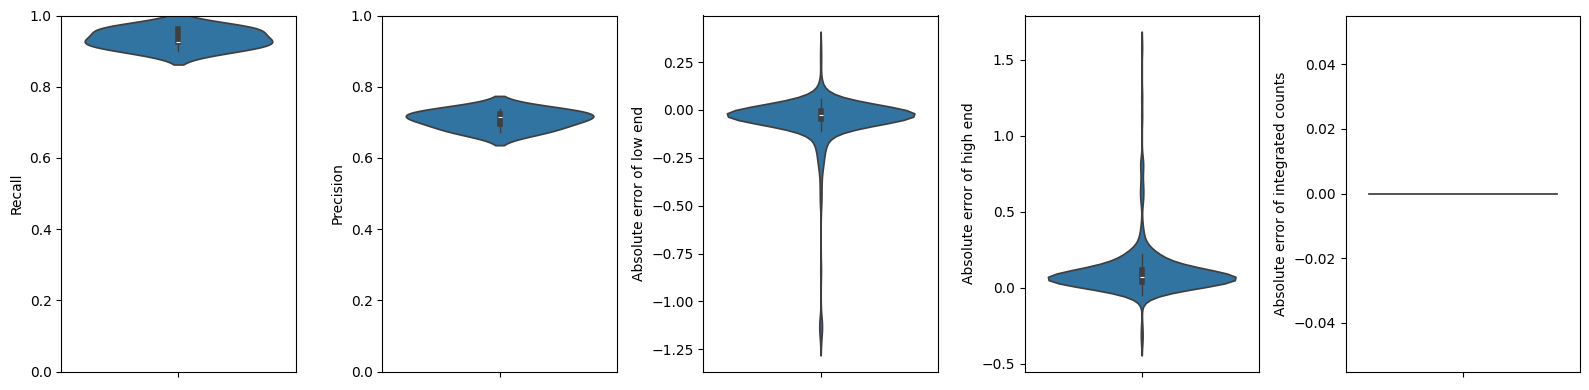

In [9]:
import seaborn as sns
%matplotlib inline 
plt.close('all')
fig, axes = plt.subplots(1, 5, figsize=[16, 4])
#fig.suptitle('R2001_185741ZrSiO UW Analysis Zircon', fontsize=16) # R16_50678 NiPdSi Top Level ROI' 'R6012_264025 7000Al'

axs = sns.violinplot(data=recall, inner_kws=dict(box_width=4, whis_width=1,), ax=axes[0] )
axs.set_ylabel('Recall')
axs.set_ylim(0,1)

axs = sns.violinplot(data=precision, inner_kws=dict(box_width=4, whis_width=1,), ax=axes[1] )
axs.set_ylabel('Precision')
axs.set_ylim(0,1)

axs = sns.violinplot(data=low_ae, inner_kws=dict(box_width=4, whis_width=1,),  ax=axes[2] )
axs.set_ylabel('Absolute error of low end')
axs = sns.violinplot(data=high_ae, inner_kws=dict(box_width=4, whis_width=1,),  ax=axes[3] )
axs.set_ylabel('Absolute error of high end')
axs = sns.violinplot(data=sp_counts_ae, inner_kws=dict(box_width=4, whis_width=1,),  ax=axes[4])
axs.set_ylabel('Absolute error of integrated counts')

fig.tight_layout()
print('Mean recall:', np.round(recall.mean(), 3))
print('Mean precision:', np.round(precision.mean(), 3))
print('Mean error (Da) of low end:', np.round(low_ae.mean().numpy(), 3))
print('Mean error (Da) of high end:', np.round(high_ae.mean().numpy(), 3))
print('Mean error of integrated counts:', np.round(sp_counts_ae.mean().numpy(), 3))

In [15]:
file = '/srv/home/jwei74/APT_ML/ranging/hdf5s/R6012_264025 7000Al UW Ranging.h5'
modelpath = "/srv/home/jwei74/APT_ML/ranging/model_latest_P234/weights/best.pt"

cfg = '/srv/home/jwei74/APT_ML/ranging/prediction_args.yaml'
save_dir = '/srv/home/jwei74/APT_ML/test_result/'
import h5py, torch
import numpy as np
from peak_detection.RangingNN.predictor import DetectionPredictor
with h5py.File(file, "r") as f:
    array = np.asarray(f['input'])[:,None, :]
    array_raw = np.asarray(f['non_log_spectrums'])[:,None, :]
    gt = np.asarray(f['label'])
    sp = torch.tensor(array, dtype=torch.float32)

/tmp/ipykernel_2469671/532653062.py:10: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  array = np.asarray(f['input'])[:,None, :]
/tmp/ipykernel_2469671/532653062.py:11: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  array_raw = np.asarray(f['non_log_spectrums'])[:,None, :]
/tmp/ipykernel_2469671/532653062.py:12: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gt = np.asarray(f['label'])


/srv/home/jwei74/APT_ML/ranging/hdf5s/R6012_264025 7000Al UW Ranging.h5
WARNING ⚠️ torch.Tensor inputs should be BCH i.e. shape(batch, 1, 30720) divisible by stride 32. Input shape(1, 30720) is incompatible.Added one extra channel dimension
Start inference
Speed:  224.2ms inference, 13.4ms postprocess for per spectrum 
labeled peaks: 81 ; model predicted peaks: 90


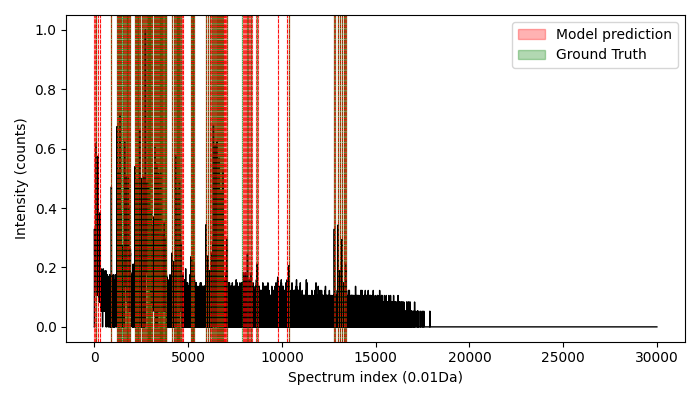

In [16]:
%matplotlib widget
print(file)
import matplotlib.pyplot as plt
fig,ax = plot_prediction(dataindex=99, plot_max = 30000, plot_min = 0, log = True)

# backup

In [ ]:
import io
from subprocess import Popen, PIPE
import matplotlib.pyplot as plt

num_frames = 9
fps = 1

file_output = 'movie.mp4'

# Make sure file doesn't exist
!rm -f {file_output}

# init file writing
p = Popen(['ffmpeg', '-y', '-f',
           'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', 
           '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p',
           file_output], stdin=PIPE)

dataindex_all = [100,200,300,400,500,600,700,800,900,1000]

for a0 in range(num_frames):
    fig, ax = plot_prediction(dataindex=dataindex_all[a0], plot_max=1700, plot_min=0)
    
    # Draw the figure
    fig.canvas.draw()
    
    # Save figure to a BytesIO object
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    
    # Write to pipe
    p.stdin.write(buf.getvalue())
    p.stdin.flush()
    
    plt.close(fig)

p.stdin.close()
p.wait()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from RangingNN.model_utils import cw2lh

# Generate sample data for the spectrum
plot_max = 4000
plot_min = 0000
peak_ranges = result[:,:2].cpu()
peak_ranges = peak_ranges[(peak_ranges[:,0] < plot_max) & (peak_ranges[:,0] >plot_min) ]

gt_ranges = cw2lh(gt[dataindex] * 30720)# target ranges denormalized, in pixels
gt_ranges = gt_ranges[(gt_ranges[:,0] < plot_max) & (gt_ranges[:,0] >plot_min)]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the spectrum
x = torch.linspace(plot_min,plot_max, plot_max- plot_min)

ax.plot(x[...,None], sp[dataindex].cpu()[..., plot_min:plot_max].T, 'k-', linewidth=1)

# Add color boxes for each peak range
for start, end in peak_ranges:
    ax.axvspan(start, end, alpha=0.3, color='red',label='Model prediction' if start == peak_ranges[0][0] else "")

for start, end in gt_ranges:
    ax.axvspan(start, end, alpha=0.5, color='green',label='Ground Truth'if start == gt_ranges[0][0] else "")
    
# Add vertical lines to show the boundaries of ranges
for start, end in peak_ranges:
    ax.axvline(start, color='red', linestyle='--', alpha=0.7, lw = 0.7)
    ax.axvline(end, color='red', linestyle='--', alpha=0.7, lw = 0.7)

for start, end in gt_ranges:
    ax.axvline(start, color='green', linestyle=':', alpha=0.7, lw = 0.5)
    ax.axvline(end, color='green', linestyle=':', alpha=0.7, lw = 0.5)
    
# Set labels and title
ax.set_xlabel('Spectrum index (0.01Da)')
ax.set_ylabel('Normalized Intensity')

# Adjust the plot layout
plt.tight_layout()
plt.legend()
# Show the plot
plt.show()

NameError: name 'result' is not defined

In [ ]:
import torch
import os,sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
from RangingNN.trainer import BaseTrainer
from RangingNN.model_utils import cw2lh
from pathlib import Path
import yaml
torch.cuda.is_available(),torch.__version__

def grid_search(param_grid, yaml_rootfile, modelfilename):
    # Get the parameter combination from command line argument
    combo_index = int(sys.argv[1])
    yaml_dict = yaml.safe_load(Path(yaml_rootfile).read_text())

    # Generate all parameter combinations
    param_combinations = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    
    # Get the specific parameter combination for this job
    params = param_combinations[combo_index]
    
    # Create model configuration
    yaml_dict['conf']=params['conf']
    yaml_dict['iou']=params['iou']
    yaml_dict['cls']=params['cls']
    yaml_dict['save_dir']='/srv/home/jwei74/APT_ML/ranging/model_'+str(combo_index) 
    yaml_dict['model']='/srv/home/jwei74/APT_ML/ranging/'+modelfilename

    trainer = BaseTrainer(cfg=yaml_dict)
    trainer.train()
    
if __name__ == "__main__":
    # Define parameter grid
    param_grid = {
        'conf': [0.5, 5, 10, 15],
        'iou': [ 0.7, 0.5, 0.2, 0.1],
        'cls': [0.5, 5, 10, 15],
    }
    yaml_rootfile = "/srv/home/jwei74/APT_ML/ranging/current_all_args.yaml"
    grid_search(param_grid,yaml_rootfile, 'yolov8_p234.yaml')
# trainer._setup_train(1)
# for i, it in enumerate(trainer.train_loader):
#     if i>2:
#         break
#     print(i, it['file'])